In [1]:
import zarr
import numpy as np

# === Your Zarr ===
DIR = '/mnt/efs/aimbl_2025/student_data/S-LS/marker_data.zarr'
z_data = zarr.open(DIR, mode='r')

# === Datasets (as you named them) ===
masks  = z_data['pred_mask_bacteria']['pred_mask_stack'][:]   # (N,H,W), int labels (0=bg, 1..K)
marker = z_data['marker']['marker_stack'][:]                  # (N,H,W), uint16 intensities
raw    = z_data['bacteria']['raw_bacteria_stack'][:]         # (N,H,W), raw image for context

N, H, W = raw.shape
print("shape:", (N, H, W), masks.dtype, marker.dtype, raw.dtype)

shape: (72, 2208, 2752) uint16 uint16 uint16


defining functions

In [2]:
from skimage.segmentation import expand_labels, find_boundaries
from skimage.morphology import erosion, disk
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt

def band_two_sided(labels2d: np.ndarray, r_out: int = 2, r_in: int = 1) -> np.ndarray:
    """
    Two-sided label-preserving band around each object:
      - Outer band = expand_labels(labels, r_out) minus original labels
      - Inner band = original labels minus per-object erosion by disk(r_in)
    Returns band_labels: same ids as labels on band pixels, 0 elsewhere.
    """
    labels2d = labels2d.astype(np.int32, copy=False)

    # Outer band (keeps instances separate)
    r_out = int(max(0, r_out))
    expanded = expand_labels(labels2d, distance=r_out) if r_out > 0 else labels2d
    outer = expanded.copy()
    outer[labels2d != 0] = 0  # only the newly added outside ring

    # Inner band (per-object erosion to get a thin inner ring)
    r_in = int(max(0, r_in))
    if r_in > 0:
        se = disk(r_in)
        inner = np.zeros_like(labels2d, dtype=np.int32)
        for oid in np.unique(labels2d):
            if oid == 0:
                continue
            obj = (labels2d == oid)
            er = erosion(obj, se)                 # shrink object inward
            inner_ring = obj & (~er)              # original minus eroded = inner band
            inner[inner_ring] = oid
    else:
        inner = np.zeros_like(labels2d, dtype=np.int32)

    band = inner.copy()
    band[outer != 0] = outer[outer != 0]          # union of inner+outer bands
    return band

def band_coverage_per_label(band_labels: np.ndarray, marker2d: np.ndarray, thr: int, return_area=False):
    """
    Coverage fraction per label on the band:
      coverage[label] = (# band pixels with marker >= thr) / (band area)
    marker2d is uint16; thr should be uint16-ish (e.g., 1200).
    """
    if band_labels.max() == 0:
        return ({}, {}) if return_area else {}

    pos = (marker2d >= thr).astype(np.uint8)  # boolean -> 0/1 so mean = fraction
    props = regionprops_table(
        band_labels, intensity_image=pos,
        properties=("label", "mean_intensity", "area")
    )
    coverage = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])}
    if return_area:
        area = {int(l): int(a) for l, a in zip(props["label"], props["area"])}
        return coverage, area
    return coverage

def band_intensity_stats(band_labels: np.ndarray, marker2d: np.ndarray):
    """
    (Optional) Mean/Max intensity per label on the band (not thresholded).
    Useful for exploring intensity distributions before picking a threshold.
    """
    if band_labels.max() == 0:
        return {}, {}, {}, {}
    props = regionprops_table(
        band_labels, intensity_image=marker2d.astype(np.float32),
        properties=("label", "mean_intensity", "max_intensity", "area", "bbox", "centroid")
    )
    mean_by = {int(l): float(m) for l, m in zip(props["label"], props["mean_intensity"])}
    max_by  = {int(l): float(m) for l, m in zip(props["label"], props["max_intensity"])}
    area_by = {int(l): int(a)   for l, a in zip(props["label"], props["area"])}
    bbox_by = {
        int(l): (int(r0), int(c0), int(r1), int(c1))
        for l, r0, c0, r1, c1 in zip(
            props["label"], props["bbox-0"], props["bbox-1"], props["bbox-2"], props["bbox-3"]
        )
    }
    return mean_by, max_by, area_by, bbox_by

def crop_with_margin(y0, x0, y1, x1, margin, H, W):
    y0 = max(0, y0 - margin); x0 = max(0, x0 - margin)
    y1 = min(H, y1 + margin); x1 = min(W, x1 + margin)
    return y0, x0, y1, x1

def rescale_for_display(arr, p_lo=1, p_hi=99.5):
    """Percentile-based rescale to [0,1] for prettier plots (doesn't affect analysis)."""
    a = arr.astype(np.float32)
    lo, hi = np.percentile(a, [p_lo, p_hi])
    if hi <= lo:
        return np.clip((a - lo), 0, 1)
    a = (a - lo) / (hi - lo)
    return np.clip(a, 0, 1)

2) Index instances once (band, per-label stats, bbox) for fast browsing

In [3]:
R_OUT = 2   # outer pixels
R_IN  = 1   # inner pixels

index = []  # list of dicts: {img_i, label, mean, max, bbox}

#for i in range(N):
for i in range(3):
    lbl = masks[i]
    if lbl.max() == 0:
        continue
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)
    mean_by, max_by, area_by, bbox_by = band_intensity_stats(band, marker[i])

    for oid, bbox in bbox_by.items():
        index.append({
            "img_i": i,
            "label": int(oid),
            "mean": float(mean_by.get(oid, 0.0)),
            "max":  float(max_by.get(oid, 0.0)),
            "bbox": bbox
        })
    print("Finished image", i)

print(f"Indexed {len(index)} instances across {N} images (r_out={R_OUT}, r_in={R_IN}).")

Finished image 0
Finished image 1
Finished image 2
Indexed 529 instances across 72 images (r_out=2, r_in=1).


3) Visual browser without any threshold (to help you pick one)

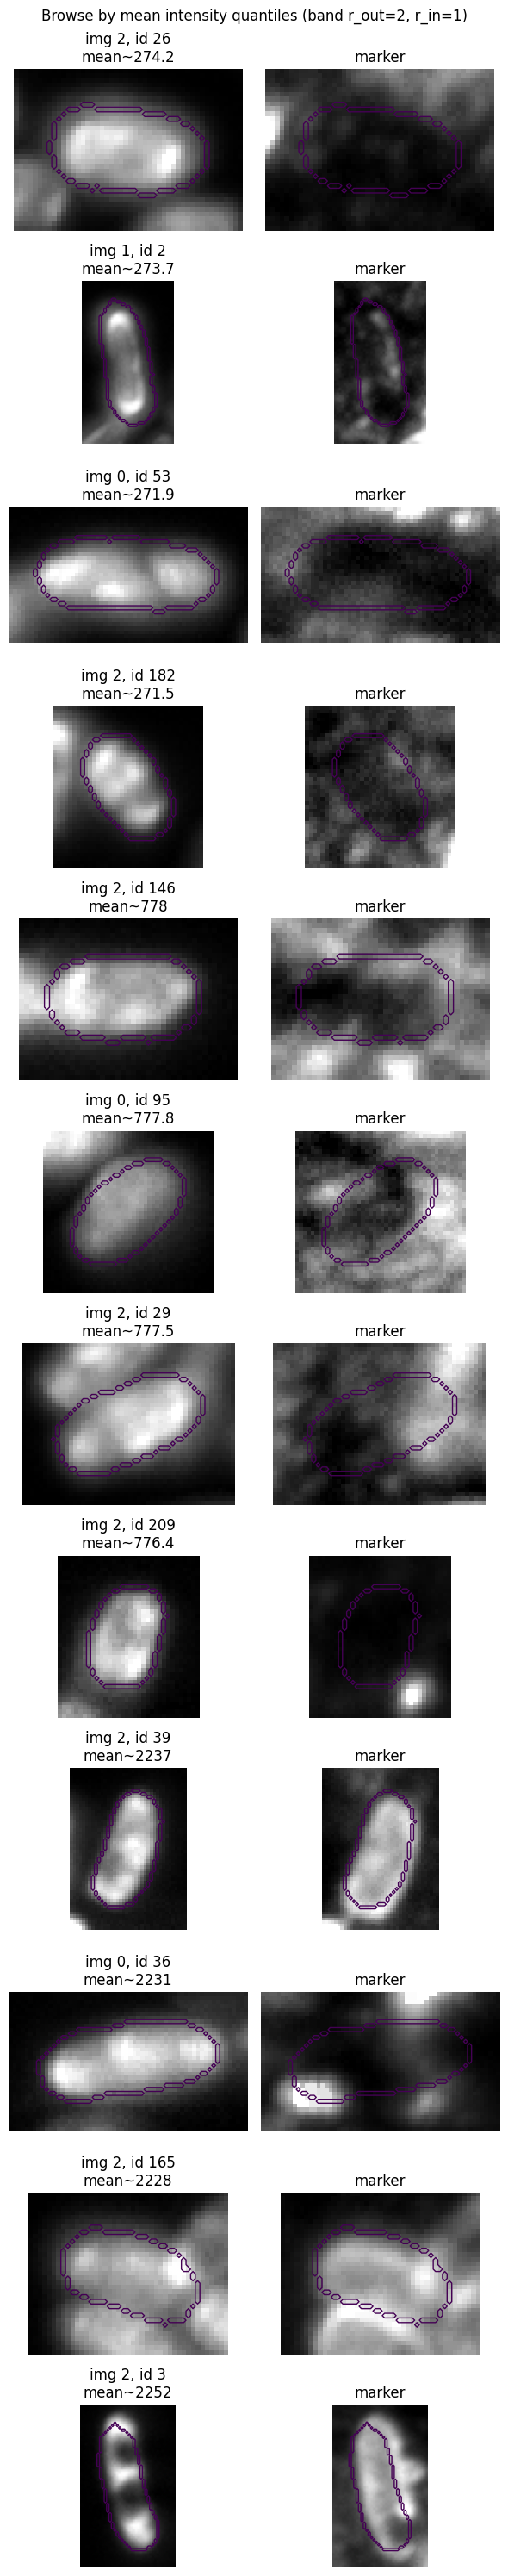

In [12]:
import numpy as np

def show_by_quantiles(index, measure="mean", quantiles=(0.1, 0.5, 0.9), per_q=4, margin=6, seed=0):
    """
    Show examples at selected quantiles of the per-label band intensity (mean or max).
    Lets you see what 'low', 'mid', 'high' signal looks like before choosing THR.
    """
    rng = np.random.default_rng(seed)
    vals = np.array([it[measure] for it in index], dtype=float)
    if vals.size == 0:
        print("No instances to display.")
        return

    qs = np.clip(np.array(quantiles), 0, 1)
    cutoffs = [float(np.quantile(vals, q)) for q in qs]

    rows = len(quantiles) * per_q
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(6, 2.5*rows))
    if rows == 1:
        axes = np.array([axes])

    row = 0
    for q, c in zip(quantiles, cutoffs):
        # pick items closest to this cutoff
        d = np.abs(vals - c)
        order = np.argsort(d)
        chosen = order[:per_q]
        chosen = rng.choice(chosen, size=per_q, replace=False) if len(chosen) > per_q else chosen

        for k in chosen:
            item = index[int(k)]
            i, oid = item["img_i"], item["label"]
            y0, x0, y1, x1 = crop_with_margin(*item["bbox"], margin, H, W)
            img_raw = rescale_for_display(raw[i][y0:y1, x0:x1])
            img_mrk = rescale_for_display(marker[i][y0:y1, x0:x1].astype(np.float32))

            lbl_crop = (masks[i][y0:y1, x0:x1] == oid)
            bnd_crop = find_boundaries(lbl_crop, mode="outer")

            axL = axes[row, 0]
            axL.imshow(img_raw, cmap="gray")
            axL.contour(bnd_crop, levels=[0.5], linewidths=1.0)
            axL.set_title(f"img {i}, id {oid}\n{measure}~{item[measure]:.4g}")
            axL.axis("off")

            axR = axes[row, 1]
            axR.imshow(img_mrk, cmap="gray")
            axR.contour(bnd_crop, levels=[0.5], linewidths=1.0)
            axR.set_title("marker")
            axR.axis("off")

            row += 1

    fig.suptitle(f"Browse by {measure} intensity quantiles (band r_out={R_OUT}, r_in={R_IN})", y=0.995)
    plt.tight_layout()
    plt.show()

# === Browse a few sets to get a feel for brightness ===
show_by_quantiles(index, measure="mean", quantiles=(0.1, 0.5, 0.9), per_q=4, margin=6, seed=1)
# You can also try measure="max"
# show_by_quantiles(index, measure="max", quantiles=(0.1, 0.5, 0.9), per_q=4)

compute a global Otsu on band pixels only:

In [6]:
from skimage.filters import threshold_otsu

# Collect all band pixels across the dataset to suggest a global threshold
all_band_vals = []
# for i in range(N):
for i in range(3):
    band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
    vals = marker[i][band != 0]
    if vals.size:
        all_band_vals.append(vals.astype(np.uint16))
all_band_vals = np.concatenate(all_band_vals) if all_band_vals else np.array([], dtype=np.uint16)

if all_band_vals.size:
    otsu_thr = int(threshold_otsu(all_band_vals))
    p10, p50, p90 = np.percentile(all_band_vals, [10, 50, 90])
    print(f"Global Otsu (band pixels): {otsu_thr} | band percentiles: p10={p10:.0f}, p50={p50:.0f}, p90={p90:.0f}")
else:
    print("No band pixels found for Otsu.")

Global Otsu (band pixels): 1676 | band percentiles: p10=209, p50=633, p90=2518


4) Visualize positives / near / negatives given a candidate THR + coverage

In [8]:
def show_examples_coverage(index, thr: int, coverage_min=0.5, n=12, mode="positive", margin=6, seed=0):
    """
    mode: 'positive' (coverage>=min), 'negative' (<min), 'near' (within ±10% of min)
    """
    rng = np.random.default_rng(seed)

    # Compute coverage per instance (given thr) on the fly
    cov_vals = []
    for item in index:
        i, oid = item["img_i"], item["label"]
        band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
        cov = band_coverage_per_label(band, marker[i], thr=thr)
        cov_vals.append(cov.get(oid, 0.0))
    cov_vals = np.array(cov_vals, dtype=float)

    if mode == "positive":
        sel = np.where(cov_vals >= coverage_min)[0]
    elif mode == "negative":
        sel = np.where(cov_vals < coverage_min)[0]
    elif mode == "near":
        lo, hi = 0.9*coverage_min, 1.1*coverage_min
        sel = np.where((cov_vals >= lo) & (cov_vals <= hi))[0]
    else:
        raise ValueError("mode must be 'positive', 'negative', or 'near'")

    if sel.size == 0:
        print("No examples match this filter.")
        return

    rng.shuffle(sel)
    sel = sel[:n]
    rows = len(sel); cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(6, 2.5*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, k in enumerate(sel):
        item = index[int(k)]
        i, oid = item["img_i"], item["label"]
        y0, x0, y1, x1 = crop_with_margin(*item["bbox"], margin, H, W)

        img_raw = rescale_for_display(raw[i][y0:y1, x0:x1])
        img_mrk = rescale_for_display(marker[i][y0:y1, x0:x1].astype(np.float32))

        # Build overlays
        lbl_crop  = (masks[i][y0:y1, x0:x1] == oid)
        bnd_crop  = find_boundaries(lbl_crop, mode="outer")
        full_band = band_two_sided(masks[i], r_out=R_OUT, r_in=R_IN)
        band_crop = (full_band[y0:y1, x0:x1] == oid)

        # Coverage again for this object (for annotation)
        cov = band_coverage_per_label(full_band, marker[i], thr=thr).get(oid, 0.0)

        axL = axes[r, 0]
        axL.imshow(img_raw, cmap="gray")
        axL.contour(bnd_crop, levels=[0.5], linewidths=1.0)
        axL.set_title(f"img {i}, id {oid}\ncoverage={cov:.2f}")
        axL.axis("off")

        axR = axes[r, 1]
        axR.imshow(img_mrk, cmap="gray")
        axR.contour(band_crop, levels=[0.5], linewidths=1.0)
        axR.set_title(f"marker ≥ {thr} (uint16)\nband r_out={R_OUT}, r_in={R_IN}")
        axR.axis("off")

    fig.suptitle(f"Examples ({mode}) — coverage≥{coverage_min}", y=0.995)
    plt.tight_layout()
    plt.show()

# # === Pick a candidate threshold in uint16, then preview ===
# THR_CANDIDATE = 1200   # <-- choose based on browsing / Otsu / biology
# show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="positive", margin=6, seed=1)
# show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="near",     margin=6, seed=2)
# show_examples_coverage(index, thr=THR_CANDIDATE, coverage_min=0.5, n=10, mode="negative", margin=6, seed=3)

In [9]:
# Try a few candidates around Otsu and the med/high you eyeballed
thr_candidates = [int(0.8*otsu_thr), otsu_thr, int(1.2*otsu_thr)]
# You can also add a percentile-based candidate if useful, e.g., int(p75) or int(p90)

for thr in thr_candidates:
    print(f"\n=== THRESHOLD CANDIDATE: {thr} (uint16) ===")
    # Clearly positive examples
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="positive", margin=6, seed=1)
    # Borderline ones—these decide your final choice
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="near",     margin=6, seed=2)
    # Negatives—sanity check you’re not missing obvious trues
    show_examples_coverage(index, thr=thr, coverage_min=0.5, n=8, mode="negative", margin=6, seed=3)


=== THRESHOLD CANDIDATE: 1340 (uint16) ===


KeyboardInterrupt: 

5) Final counting over the whole stack (your definition of positive)

In [10]:
COVERAGE_MIN = 0.5       # "at least half the band"
THR = 4200     # set after you’re happy with the visuals

total_pos = total_inst = 0
per_image = []

# for i in range(N):
for i in range(3):
    lbl = masks[i]
    mrk = marker[i]
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)

    coverage, area = band_coverage_per_label(band, mrk, thr=THR, return_area=True)
    ids = np.unique(lbl); ids = ids[ids != 0]
    n_inst = int(len(ids))
    n_pos  = sum(1 for oid in ids if coverage.get(int(oid), 0.0) >= COVERAGE_MIN)

    total_pos += n_pos
    total_inst += n_inst
    per_image.append((i, n_inst, n_pos))

print(f"Band: r_out={R_OUT}, r_in={R_IN} | Marker thr={THR} (uint16) | Coverage≥{COVERAGE_MIN}")
print(f"Colocalizing bacteria: {total_pos}/{total_inst}  ({100*total_pos/max(total_inst,1):.1f}%)")
for i, n_inst, n_pos in per_image:
    print(f"Image {i:03d}: positives={n_pos}/{n_inst}")

Band: r_out=2, r_in=1 | Marker thr=4200 (uint16) | Coverage≥0.5
Colocalizing bacteria: 3/529  (0.6%)
Image 000: positives=2/136
Image 001: positives=1/128
Image 002: positives=0/265


In [11]:
COVERAGE_MIN = 0.5       # "at least half the band"
THR = 1676     # set after you’re happy with the visuals

total_pos = total_inst = 0
per_image = []

# for i in range(N):
for i in range(3):
    lbl = masks[i]
    mrk = marker[i]
    band = band_two_sided(lbl, r_out=R_OUT, r_in=R_IN)

    coverage, area = band_coverage_per_label(band, mrk, thr=THR, return_area=True)
    ids = np.unique(lbl); ids = ids[ids != 0]
    n_inst = int(len(ids))
    n_pos  = sum(1 for oid in ids if coverage.get(int(oid), 0.0) >= COVERAGE_MIN)

    total_pos += n_pos
    total_inst += n_inst
    per_image.append((i, n_inst, n_pos))

print(f"Band: r_out={R_OUT}, r_in={R_IN} | Marker thr={THR} (uint16) | Coverage≥{COVERAGE_MIN}")
print(f"Colocalizing bacteria: {total_pos}/{total_inst}  ({100*total_pos/max(total_inst,1):.1f}%)")
for i, n_inst, n_pos in per_image:
    print(f"Image {i:03d}: positives={n_pos}/{n_inst}")

Band: r_out=2, r_in=1 | Marker thr=1676 (uint16) | Coverage≥0.5
Colocalizing bacteria: 90/529  (17.0%)
Image 000: positives=27/136
Image 001: positives=29/128
Image 002: positives=34/265


In [ ]:
# import numpy as np
# from skimage.segmentation import expand_labels
# from skimage.measure import regionprops_table

# def ring_from_labels(labels2d: np.ndarray, radius: int = 2) -> np.ndarray:
#     """Outer ring per instance using label-preserving expansion."""
#     expanded = expand_labels(labels2d, distance=radius)
#     ring = expanded.copy()
#     ring[labels2d != 0] = 0  #  sets all the pixels in ring that correspond to the original label areas back to zero
#     return ring



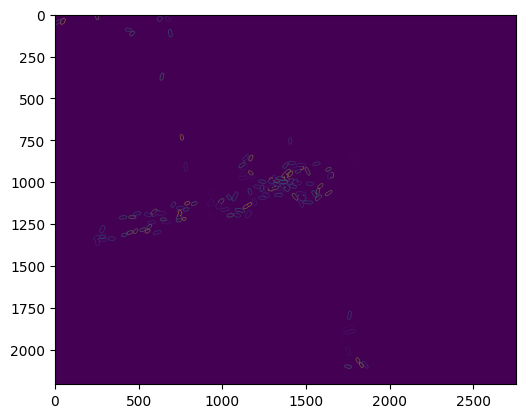

In [7]:
import matplotlib.pyplot as plt
ring_0=ring_from_labels(masks[0], 2) 

plt.imshow(masks[0])
plt.imshow(ring_0)



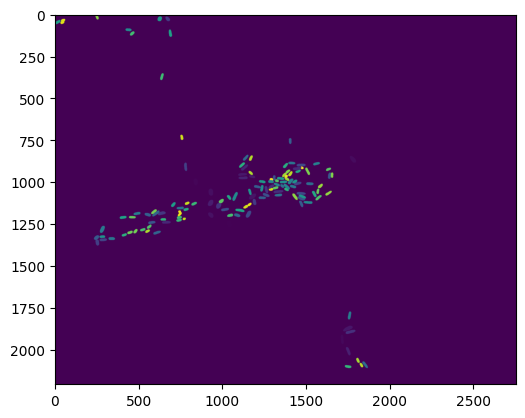

In [8]:
plt.imshow(masks[0])

In [12]:
x=ring_intensity_stats(ring_0, marker[0])

print(x[0])

{1: 406.7383177570093, 2: 167.61682242990653, 3: 3034.34375, 4: 257.83482142857144, 5: 689.8073394495412, 6: 460.8578947368421, 7: 2014.6634615384614, 8: 2707.2988505747126, 9: 789.2291666666666, 10: 288.52866242038215, 11: 426.1952380952381, 12: 2391.8491379310344, 13: 2283.72131147541, 14: 704.0666666666667, 15: 696.2780269058296, 16: 903.75, 17: 454.25, 18: 1595.4642857142858, 19: 2370.50390625, 20: 1109.9828571428573, 21: 2365.9417475728155, 22: 820.7578947368421, 23: 911.1827956989247, 24: 451.644578313253, 25: 616.7134146341464, 26: 324.1336206896552, 27: 359.43859649122805, 28: 3621.8865979381444, 29: 911.96875, 30: 351.22727272727275, 31: 1025.1690821256038, 32: 1227.0181818181818, 33: 674.3979057591623, 34: 773.1290322580645, 35: 1551.1328125, 36: 2276.8805970149256, 37: 932.1857142857143, 38: 394.06164383561645, 39: 222.67525773195877, 40: 1945.3687150837989, 41: 2217.212643678161, 42: 1354.095744680851, 43: 344.42439024390245, 44: 466.8878504672897, 45: 3114.5882352941176, 4